In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
import os
import tensorflow as tf

In [75]:
!gdown  1TU1Wa5AbqPUWoTbirELibEiBaou5P08z
!unzip /content/Felidae.zip

Downloading...
From: https://drive.google.com/uc?id=1TU1Wa5AbqPUWoTbirELibEiBaou5P08z
To: /content/Felidae.zip
100% 152M/152M [00:00<00:00, 297MB/s]
Archive:  /content/Felidae.zip
replace Felidae/Cheetah/Cheetah_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Felidae/Cheetah/Cheetah_002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Felidae/Cheetah/Cheetah_003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data = []
target = []
new_size = (224,224)
os.chdir("/content/Felidae")
for folder in os.listdir():
    os.chdir(folder)
    for file in os.listdir():
        # opening and resizing the image
        img = PIL.Image.open(file)
        img_res = np.array(img.resize(new_size))
        
        # adding data and target to arrays
        data.append(img_res)
        target.append(folder)
    os.chdir('..')
os.chdir("/content/")
wrong_imgs_idx = []

# checking if all pics are in RGB and adding incorrect indexes to list
for idx,img in enumerate(data):
    try:
        if img.shape[2] != 3:
            wrong_imgs_idx.append(idx)
    except:
        if len(img.shape) != 3:
            wrong_imgs_idx.append(idx)
a= 0
for idx in wrong_imgs_idx:
    del data[idx-a]
    del target[idx-a]
    a += 1
try:
    data = np.array(data)
    target = np.array(target)
except:
    print('Problem with broadcast')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
target_n = lbl.fit_transform(target)
x_train, x_test, y_train, y_test = train_test_split(data,target_n,test_size=0.25,stratify=target)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (180, 224, 224, 3)
x_test shape: (61, 224, 224, 3)
y_train shape: (180,)
y_test shape: (61,)


In [ ]:
from tensorflow.keras.utils import to_categorical
x_train_n = x_train / 255
x_test_n = x_test / 255
y_train_cat = to_categorical(y_train,num_classes=len(set(y_train)))
y_test_cat = to_categorical(y_test,num_classes=len(set(y_test)))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest', 
    validation_split = .25
)

valid_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = .25
)
os.chdir("/content/")
data_dir = 'Felidae'

train_data = train_datagen.flow_from_directory(data_dir, target_size = (224,224), class_mode = 'categorical',
                                        subset = 'training')

val_data = valid_datagen.flow_from_directory(data_dir, target_size =  (224,224), class_mode = 'categorical',
                                        subset = 'validation')

Found 183 images belonging to 5 classes.
Found 60 images belonging to 5 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet',include_top=False)

for layer in vgg16.layers:
    layer.trainable = False
x1 = layers.Flatten()(vgg16.output)
x2 = layers.Dense(5,activation='softmax')(x1)

model = Model(inputs=vgg16.input,outputs=x2)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])


58900480/58889256 [==============================] - 0s 0us/step


In [67]:
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=50,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
acc=[]
vacc=[]
class Points(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    acc.append(logs.get("accuracy"))
    vacc.append(logs.get("val_accuracy"))


callback=Mycallbacks()
points=Points()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    callbacks=[es,points]
)

Epoch 1/200
6/6 [==============================] - 11s 2s/step - loss: 0.5845 - accuracy: 0.8579 - val_loss: 0.9232 - val_accuracy: 0.7833
Epoch 2/200
6/6 [==============================] - 10s 2s/step - loss: 0.1943 - accuracy: 0.9454 - val_loss: 0.9020 - val_accuracy: 0.7667
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 0.0483 - accuracy: 0.9836 - val_loss: 1.0386 - val_accuracy: 0.7333
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.3569 - accuracy: 0.8689 - val_loss: 0.9625 - val_accuracy: 0.6833
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.2391 - accuracy: 0.9235 - val_loss: 1.2198 - val_accuracy: 0.7167
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.2928 - accuracy: 0.8907 - val_loss: 1.8916 - val_accuracy: 0.7500
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.1896 - accuracy: 0.9235 - val_loss: 0.8074 - val_accuracy: 0.8000
Epoch 8/200
6/6 [==========

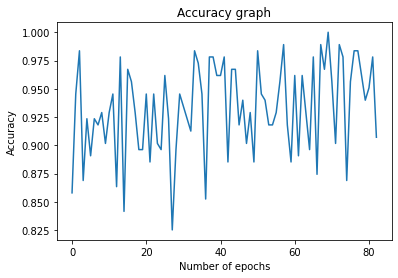

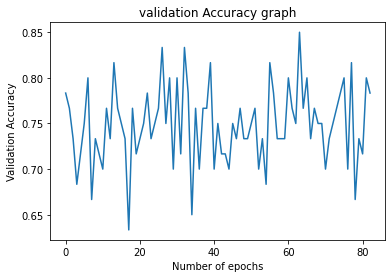

In [72]:
y=[x for x in range(len(acc))]

plt.plot(y,acc)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy graph')
plt.show()

plt.plot(y,vacc) 
plt.xlabel("Number of epochs")
plt.ylabel("Validation Accuracy")
plt.title('validation Accuracy graph')
plt.show()

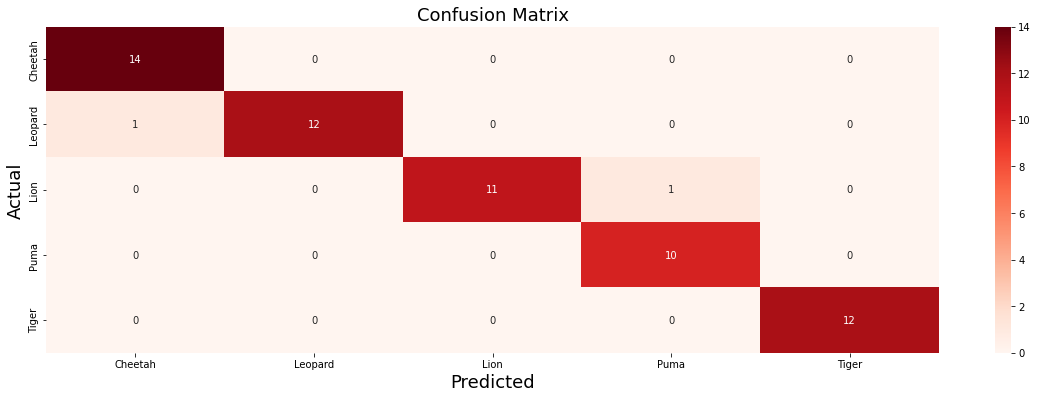

In [73]:
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
set(lbl.inverse_transform(y_test))
classes = ['Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger']
y_pred = model.predict(x_test_n).argmax(1)
y_true = y_test
con_matrixes = [confusion_matrix(y_pred=y_pred,y_true=y_true)]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
for i in range(1):
    sns.heatmap(con_matrixes[0],cmap='Reds',annot=True,fmt='g')
    ax.set_title('Confusion Matrix',size=18)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
ax.set_ylabel('Actual',size=18)
ax.set_xlabel('Predicted',size=18)
plt.show()

Enter the number corresponding to object you want to check
0: Cheetah
1: Leopard
2: Lion
3: Puma
4: Tiger
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


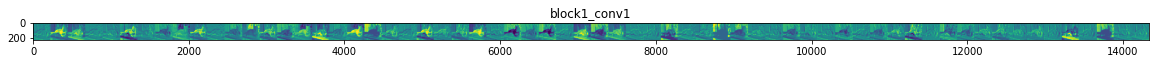

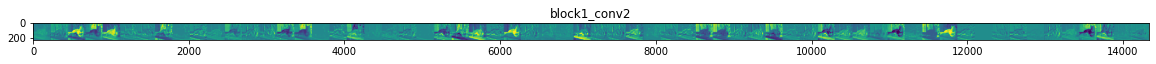

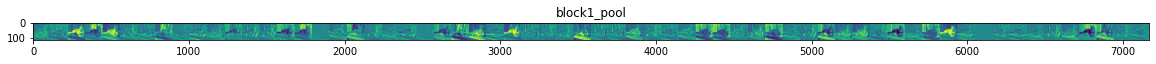

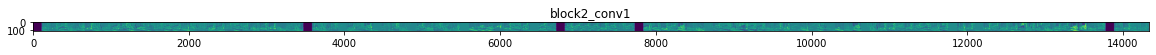

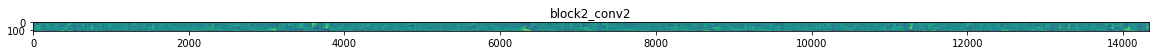

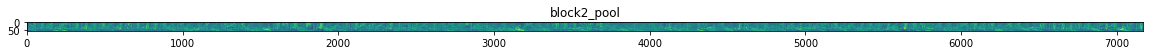

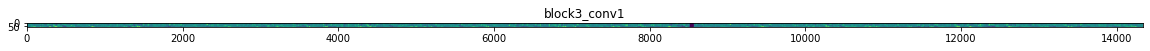

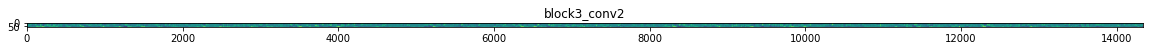

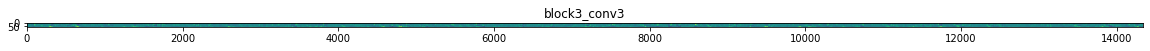

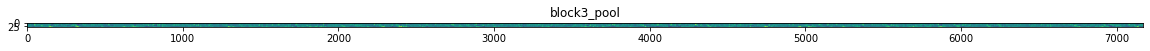

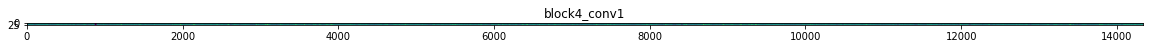

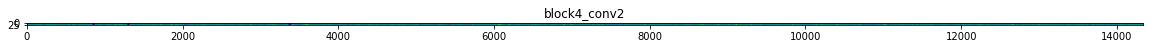

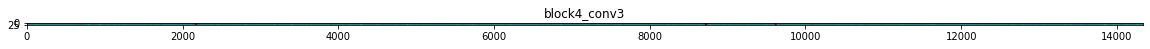

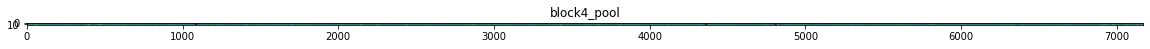

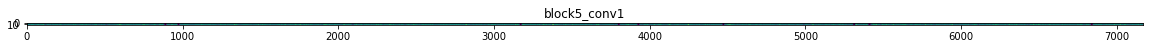

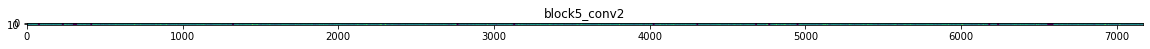

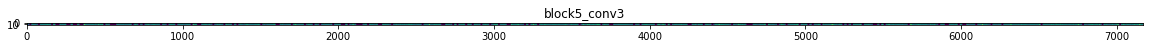

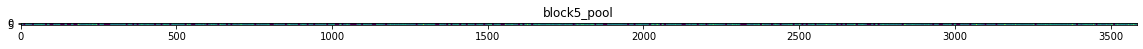

In [ ]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

billi=['Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger']
print("Enter the number corresponding to object you want to check")
for x in range(len(billi)):
  print(str(x)+":",billi[x])

num=str(input())
num=int(num)
dirpath='/content/Felidae'
if num<len(billi):
  img=random.choice(os.listdir(dirpath+"/"+billi[num]))
  img_path=dirpath+"/"+billi[num]+"/"+img
img = load_img(img_path, target_size=(224, 224)) 
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)  

x /= 255


successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers[1:]]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]  
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [74]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  a=np.argmax(classes)
  print("It is a ",billi[a])

Saving download (2).jfif to download (2) (8).jfif
It is a  Lion
